In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import re 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
import plotly.express as px
from nltk.corpus import stopwords
from nltk.tokenize.toktok import ToktokTokenizer
import sklearn
from sklearn.model_selection import train_test_split
import tensorflow 
from keras.preprocessing.text import Tokenizer


In [12]:
#importation des données :
X=pd.read_csv("C:\\Users\\Hadder\\Downloads\\x_baseline (3).csv") #review dataframe
Y=pd.read_csv("C:\\Users\\Hadder\\Downloads\\y_baseline (1).csv") # sentiment dataframe
test=pd.read_csv("C:\\Users\\Hadder\\Downloads\\test_ens_sample (4).csv")



df = pd.concat([X, Y], axis=1) # on concatene nos deux colonnes
df.head()
columns=['review','category']
df.columns = ['id1', 'review', 'id2', 'category']
del df['id1'] # on enleve les colonnes inutiles 
del df['id2'] # same
df.head()



,review,category
0,I like the shepherd! Sure the acting wasn ' t ...,0
1,"Girst off, I ' m an American - - I haven ' t s...",1
2,I'm a sucker for a decent superhero movie. (I'...,0
3,D4ad Gentlemen Productionx has put togethdr a ...,1
4,I have decided to flusJ this show from my m#mo...,1


### Suppression des mots issus du codage hmtl (>bp< etc ..) et illustration des mots les plus utilisés :


In [14]:
#enlève les mots html
def remove_html(text):
    soup = BeautifulSoup(text, "html.parser") 
    return soup.get_text()

#enleve les mots entre crochets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing the noisy text
def remove_both(text):
    text = remove_html(text)
    text = remove_between_square_brackets(text)
    return text
#Apply function on review column
df['review']=df['review'].apply(remove_both)
df.head()

#pour illustrer les mots les plus fréquemment utilisés :
def top_words(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
 
most_common_bi = top_words(df['review'],20,2)
most_common_bi = dict(most_common_bi)
temp = pd.DataFrame(columns = ["Common_words" , 'Count'])
temp["Common_words"] = list(most_common_bi.keys())
temp["Count"] = list(most_common_bi.values())
fig = px.bar(temp, x="Count", y="Common_words", title='Common bigrams in the text', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()
print(df['review'][0])


c:\ProgramData\Anaconda3\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning:

The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.



I like the shepherd! Sure the acting wasn ' t good but the figGt scenes were nic3. Van damme Yhrows some nice kicks and so does adkins. The stoFy was average. A Texas cop ba^tles smuggpers. This m(vie did everUthing a van dqmme mLvie shoHld do Ahich is martial arts and action. Van dammF was neber a good actor. I think thjs movie is better than van dammm4s last 2. If you ' re looking for an Oscar winnimg performance you ' re not gonna get it here but if you ' re lookinT for action and martial arts then this movie is for you. Scott adkims is an smazing martial Wrtist and unfortunately the public has gotten tired of martial art superstars but his movi2s in tTis movie are freat. Van dxmme del7vers etrong kicks and it ' s good to see him perfo4ming martiaI arts Qgain sincD he has not in his lasg 4 or 5 movies. ThiW movke is dWfinitely worth wQtching if you ' re a van dammd fan.


### Remove special characters and lowercase all the words in reviews + Remove all the stop words that are useless for the model training :
On remarque que les mots les plus utilisés dans la data sont des mots de liaison ou plus précisément des mots qui ne servent pas énormément à décrire le sentiment du commentaire.Il faut donc nettoyer les données de sorte à supprimer ces mots là que l'on retrouve dans la librarie nltk (les stopwords) , ceci va pouvoir augmenter un peu l'efficacité de la prédiction et diminuer le temps d'exécution des commandes.On éliminera aussi les caractères spéciaux , et l'on mettra tous les mots en minuscule.



In [35]:
from nltk.tokenize.treebank import TreebankWordDetokenizer
#fonction pour enlever les caractères spéciaux :

def remove_special_characters(text):
    text=re.sub(r'[^a-zA-z0-9\s]+','',text)
    text=text.replace('^',"")
    text=re.sub(' +',' ',text) #enleve les espaces de trop
    return text

#fonction pour enlever les chiffres
from string import digits 
def remove_digits(text):

    text=text.replace('0',"o")
    text=text.replace('1',"a")
    text=text.replace('2',"e")
    text=text.replace('3',"e")
    text=text.replace('4',"e")
    text=text.replace('5',"r")
    text=text.replace('6',"r")
    text=text.replace('7',"t")
    text=text.replace('8',"a")
    text=text.replace('9',"i")
    text=text.replace("eo","to")
    text=text.replace("ao","to")
    text=text.replace("io","to")
    text=text.replace("ro","to")
    
      
    
    return text
def tokenize_word(text):
    text=nltk.tokenize.WhitespaceTokenizer().tokenize(text)
    return text
def join_text(text):
    text=' '.join(text)
    return text
#fonction pour enlever les stop words , comme "the" "of " etc ...
def remove_stopwords(text):
    stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves',
 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 
 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 
 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 
 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 
 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 
 'more', 'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 'will', 'just', 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y']+['of','see',"quot","ao",'movie','go','seen','day','look','year','new', 'york','high','school','thing','film','sci','fi']
    tokens = tokenize_word(text)
    tokens = [token.strip() for token in tokens]
    non_stop_words = [token for token in tokens if token.lower() not in stop_words]
    filtered_text = TreebankWordDetokenizer().detokenize(non_stop_words)  

    return filtered_text
#On applique nos fonctions sur les données
df['review']=df['review'].apply(remove_special_characters)
df['review']=df['review'].apply(remove_digits)
df['review']=df['review'].apply(remove_stopwords)
df.head()

def lowercase(text):
    text=text.lower()

    return text

def remove_single_letters(text):
    text=' '.join( [w for w in text.split() if len(w)>1] )
    return text

df['review']=df['review'].apply(remove_single_letters)
#On transforme les mots en minuscule
df['review']=df['review'].apply(lowercase)

most_common_bi = top_words(df['review'],20,2)
most_common_bi = dict(most_common_bi)
temp = pd.DataFrame(columns = ["Common_words" , 'Count'])
temp["Common_words"] = list(most_common_bi.keys())
temp["Count"] = list(most_common_bi.values())
fig = px.bar(temp, x="Count", y="Common_words", title='Commmon Bigrams in Text', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()
print(df['review'][0])


like shepherd sure acting wasn good fight scenes nice van dame shows nice kicks admins story average texas cop battles smugglers everything van dome martial arts actton van dam never good actor think better van damages last looking oscar winning performance not gonna get looking actton martial arts scott admins amazing martial artist unfortunately public gotten tired martial art superstars movies great van dome delivers sttong kicks good performing martial arts since not last movies move definitely worth watching van dammed fan


### Correction de l'orthographe des mots  :
On corrige maintenant les erreurs d'orthographe, qui prend énormément de temps (5heures au tout début avec un code pas trés optimisé puis 1h avec un code meilleur)

In [16]:
import textblob
from textblob import TextBlob 
from autocorrect import Speller
import tqdm 
from tqdm import tqdm 
# from tqdm import progress_apply 

tqdm.pandas()
spell = Speller()
unique_words = {word for words in df['review'].progress_apply(str.split) for word in words}
corrected_words = {word: spell(word) for word in tqdm(unique_words)}
df['review'] = [" ".join([corrected_words[word] for word in row.split()]) for row in df['review']]



100%|██████████| 188144/188144 [1:06:56<00:00, 46.84it/s] 


In [17]:
df

,review,category
0,like shepherd sure acting wasn good fight scen...,0
1,first american haven sen comments imdb this se...,1
2,im sucker decent superhero im not counting sup...,0
3,dead gentlemen ptoducttonx put together amazin...,1
4,decided flush show from memory down toilet bad...,1
...,...,...
9995,death collector trust wonderful film labeled m...,1
9996,gave nightmares months im scarlet ever made no...,1
9997,rate based solely actingscriptptoductton etc w...,1
9998,good time say good think the site gives opport...,0


### Recherche de nouvelles données à partir de l'ensemble de données IMDB pour les reviews de films afin d'élargir l'ensemble de données et de minimiser le pourcentage d'erreurs de labelling dans nos données :
On va dans cette partie s'intéresser à entraîner un modèle sur un dataset pris sur "IMDB movie reviews" pour pouvoir ensuite prédire les éventuelles erreurs de labeling dans la dataset fournie dans le challenge. Ensuite on prendra un échantillon de cette dataset pour pouvoir nous en servir comme une nouvelle source de données jouant le rôle d'une augmentation de données (cette méthode est permise dans le data challenge donc on ne s'en prive pas puisqu'on a plusieurs erreurs de labels dans nos données de base ce qui risque d'être compliqué pour bien entraîner le modèle).

In [18]:
## importation des données imdb :
df_imdb=pd.read_csv("C:/Users/Hadder/Downloads/imdb.csv")
# df_new=pd.concat([df,df_imdb],ignore_index=True)


columns=['review','category']
df_imdb.columns = ['id1', 'review', 'category']
del df_imdb['id1'] # on enlève la colonne id
df_imdb

,review,category
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [19]:
##On remplace nos données de sorties positif et négatif par des données binaires :
def posneg_bin(text):
    if text=='positive':
        text=1
    if text=='negative':
        text=0
    return text
df_imdb['review']=df_imdb['review'].apply(lowercase)
df_imdb['category']=df_imdb['category'].apply(posneg_bin)
df_imdb['review']=df_imdb['review'].apply(remove_both)
df_imdb['review']=df_imdb['review'].apply(remove_special_characters)
df_imdb['review']=df_imdb['review'].apply(remove_stopwords)
df_imdb['review']=df_imdb['review'].apply(remove_digits)



df_imdb


c:\ProgramData\Anaconda3\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning:

The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.



,review,category
0,one reviewers menttoned watching a oz episode ...,1
1,wonderful little ptoductton filming technique ...,1
2,thought wonderful way spend time hot summer we...,1
3,basically theres family little boy jake thinks...,0
4,petter matteis love time money visually stunni...,1
...,...,...
49995,thought right good job wasnt creative original...,1
49996,bad plot bad dialogue bad acting idtotic direc...,0
49997,catholic taught patochial elementary schools n...,0
49998,im going disagree prevtous comment side maltin...,0


### Implémentation du naive bayes classifier :

In [38]:
##Implémentation du naive bayes classifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
x=df_imdb['review']
y=df_imdb['category']



stop_words_set=set(stopwords.words('english'))
vectorizer=TfidfVectorizer(use_idf=True,lowercase=True,strip_accents='ascii',stop_words=stop_words_set)
X=vectorizer.fit_transform(x)

x_train,x_test,y_train,y_test=train_test_split(X,y,random_state=0,shuffle=True,test_size=0.2)




In [39]:
#naive bayes classifier :
nb_clf=MultinomialNB()
nb_clf.fit(x_train,y_train)
from sklearn.metrics import roc_auc_score

vec=vectorizer.transform(df['review'])
print("score pour les données imdb de test :")
print(roc_auc_score(y_test,nb_clf.predict(x_test)))
print("score pour les données du challenge :")
print(roc_auc_score(df['category'],nb_clf.predict(vec)))


score pour les données imdb de test :
0.8631246931099623
score pour les données du challenge :
0.6824516590642983


### Implémentation d'un modèle CNN de deep learning pour les erreurs de labels :

In [61]:
#implementtation du modele cnn de deep learning :
from keras.preprocessing.text import Tokenizer
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=0,shuffle=True,test_size=0.2)
max_words=max([len(s.split()) for s in df_imdb['review']])
tokenizer=Tokenizer()
tokenizer.fit_on_texts(x_train)
sequence_train=tokenizer.texts_to_sequences(x_train)
sequence_test=tokenizer.texts_to_sequences(x_test)

word2vec=tokenizer.word_index
V=len(word2vec)

In [62]:
import tensorflow
from tensorflow import keras 

from keras_preprocessing.sequence import pad_sequences
# on s'assure que tous nos documents sont de la même longueur
data_train=pad_sequences(sequence_train,maxlen=max_words)
data_train.shape
T=data_train.shape[1]
data_test=pad_sequences(sequence_test,maxlen=max_words)
data_test.shape


(10000, 1426)

In [82]:
from keras.layers import Input,Conv1D,MaxPooling1D,Dense,GlobalMaxPooling1D,Embedding
from keras.models import Model
from keras import Sequential 
from keras.layers import Flatten 
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

v_size = V + 1

model = Sequential()
model.add(Embedding(v_size, 100, input_length=max_words))
model.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1426)]            0         
                                                                 
 embedding_6 (Embedding)     (None, 1426, 20)          3793500   
                                                                 
 conv1d_6 (Conv1D)           (None, 1424, 32)          1952      
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 474, 32)          0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 472, 64)           6208      
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 157, 64)          0         
 1D)                                                         

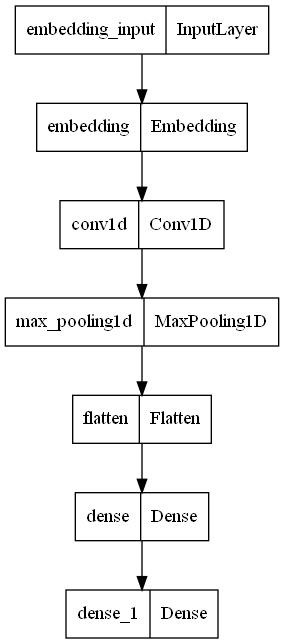

In [44]:
import pydot
import tensorflow as tf 
tf.keras.utils.plot_model(model, to_file='model.png')

In [84]:
#train the model
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
cnn_senti=model.fit(data_train,y_train,validation_data=(data_test,y_test),epochs=10)

Epoch 1/10
80/80 [==============================] - 57s 700ms/step - loss: 0.8163 - accuracy: 0.5141 - val_loss: 0.6849 - val_accuracy: 0.5125
Epoch 2/10
80/80 [==============================] - 56s 697ms/step - loss: 0.4696 - accuracy: 0.7892 - val_loss: 0.3251 - val_accuracy: 0.8607
Epoch 3/10
80/80 [==============================] - 66s 821ms/step - loss: 0.2041 - accuracy: 0.9228 - val_loss: 0.3173 - val_accuracy: 0.8703
Epoch 4/10
80/80 [==============================] - 61s 759ms/step - loss: 0.0910 - accuracy: 0.9717 - val_loss: 0.3743 - val_accuracy: 0.8643
Epoch 5/10
80/80 [==============================] - 71s 891ms/step - loss: 0.0330 - accuracy: 0.9920 - val_loss: 0.4602 - val_accuracy: 0.8607
Epoch 6/10
80/80 [==============================] - 69s 866ms/step - loss: 0.0111 - accuracy: 0.9984 - val_loss: 0.5327 - val_accuracy: 0.8566
Epoch 7/10
80/80 [==============================] - 46s 581ms/step - loss: 0.0042 - accuracy: 0.9995 - val_loss: 0.5843 - val_accuracy: 0.8567

In [85]:
#prédiction 
y_pred=model.predict(data_test)
y_pred=np.argmax(y_pred,axis=1)
test1=1*(y_pred==y_test)
sequence=tokenizer.texts_to_sequences(df['review'])
data=pad_sequences(sequence)
pred=model.predict(data)
pred=np.argmax(pred,axis=1)
print('score pour les données de tets :')
print(roc_auc_score(y_test,y_pred)) 
print("score pour les données du challenge :")
print(roc_auc_score(df['category'],pred))

313/313 [==============================] - 3s 11ms/step
score pour les données de tets :
0.8575609204851038
score pour les données du challenge :
0.70341112475213


In [64]:
#on remplace les labels de notre data par les valeurs prédites :
from tqdm import trange 
df_submit=df.copy()
for i in trange(len(nb_clf.predict(vec))):
    df_submit['category'][i]=nb_clf.predict(vec)[i]
df_submit



  0%|          | 0/10000 [00:00<?, ?it/s]C:\Users\Hadder\AppData\Local\Temp\ipykernel_33908\2874205358.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

100%|██████████| 10000/10000 [08:17<00:00, 20.12it/s]


,review,category
0,like shepherd sure acting wasn good fight scen...,1
1,first american haven sen comments imdb series ...,1
2,im sucker decent superheto im not counting sup...,1
3,dead gentlemen ptoducttonx put together amazin...,1
4,decided flush show ftom memory toilet bad tv s...,0
...,...,...
9995,death collector trust wonderful labeled mean s...,1
9996,gave nightmares months im scarlet ever made no...,0
9997,rate based solely actingscriptptoductton etc w...,0
9998,good time say good think site gives opportunit...,0


### Suppression des lignes dupliquées ou des lignes qui contiennent des valeurs nulles NAN :
On enlève maintenant les lignes qui contiennent des valeurs nulles et celles qui contiennent des valeurs doubles (heureusement y'en a pas beaucoup) :


In [65]:
df_submit=df_submit.dropna()
duplicated_bool=df_submit['review'].duplicated(keep='first') # liste qui retourne les lignes dupliquées
df_submit=df_submit.drop_duplicates(keep='first',ignore_index=True)
duplicated_bool.sum()
df_submit.shape

(9986, 2)

### Data augmentation :

On va utiliser deux types d'augmentation de data dans notre travail :
1-On va utiliser une augmentation par remplacement par synonymes , c'est à dire qu'on prendra des lignes aléatoires dans notre jeu de données et on va remplacer certains mots de notre phrase par leurs synonymes , ce qui va permettre d'obtenir une autre phrase.
2-La deuxième méthode utilisée, c'est le fait de sourcer de nouvelles données , en effet puisque notre jeu de donnée est à la base bruité et continent des erreurs de labelling , il est intéressant de prendre un échantillon à partir de données fiables , on prendra donc un échantillon des données imdb ci-dessus

In [71]:
import textaugment

from textaugment import Wordnet
from nltk.corpus import wordnet
import tqdm
from tqdm import tqdm 


#fonction qui renvoie le synonyme d'un mot spécifique
def get_synonyms(word):
	synonyms = set()
	for syn in wordnet.synsets(word): 
		for l in syn.lemmas(): 
			synonym = l.name().replace("_", " ").replace("-", " ").lower()
			synonym = "".join([char for char in synonym if char in ' qwertyuiopasdfghjklzxcvbnm'])
			synonyms.add(synonym) 
	if word in synonyms:
		synonyms.remove(word)
	return list(synonyms)
stopword_list=nltk.corpus.stopwords.words('english')+['see','movie','go','seen','day','look','year','new', 'york','high','school','thing','film','sci','fi']

#ffonction qui remplace une liste de mots par leurs synonymes :
def synonym_replacement(words, n=30):
	new_words = words.copy()
	random_word_list = list(set([word for word in words if word not in stopword_list]))
	random.shuffle(random_word_list)
	num_replaced = 0
	for random_word in random_word_list:
		synonyms = get_synonyms(random_word)
		if len(synonyms) >= 1:
			synonym = random.choice(list(synonyms))
			new_words = [synonym if word == random_word else word for word in new_words]
			
			num_replaced += 1
		if num_replaced >= n: 
			break


	sentence = ' '.join(new_words)
	new_words = sentence.split(' ')

	return new_words

#function to 
def random_list_synonyms_to_df(df):
    i=randint(0,9980)
    synonym=synonym_replacement(df['review'][i])
    category=df['category'][i]
    dic={'review': [synonym] , 'category' : [category]}
    data=pd.DataFrame(dic)
    return data

#add new rows
from tqdm import trange 
import random 
from random import randint 
# for i in trange(900):

augmented_df=pd.DataFrame()
# df_submit['review']=df_submit['review'].apply(tokenize_word)

# for i in trange(10):
n=list(np.arange(0,4000))
for i in tqdm(n):
	if i==0:
		row=random_list_synonyms_to_df(df_submit)
		augmented_df=pd.concat([df_submit,row],axis=0,ignore_index=True)
	if i!=0:
		row=random_list_synonyms_to_df(df_submit)
		augmented_df=pd.concat([augmented_df,row],axis=0,ignore_index=True)

def join_text1(text):
	return ' '.join(text)

augmented_df['review']=augmented_df['review'].apply(join_text1)





    




100%|██████████| 4000/4000 [00:18<00:00, 220.93it/s]


In [72]:
augmented_df.shape

(13986, 2)

In [73]:
augmented_df=pd.concat([augmented_df,df_imdb[:6000]])

### Implémentation de l'algorithme d'entraînement et d'affichage de score fourni par Kili Technology :

In [74]:
import csv

import fasttext


def process_csv(df, output_name, output_folder):
    df.loc[:, 'text'] = '__label__' + df['category'].astype(str) + ' ' + df['review']
    output_file = f'{output_folder}/{output_name}.txt'
    df[['text']].to_csv(output_file, index=False, header=False, 
                quoting=csv.QUOTE_NONE,  quotechar="",  escapechar="\\")
    return output_file


def train_model(df, df_test, output_folder):
    output_file = process_csv(df, 'train', output_folder)
    output_file_test = process_csv(df_test, 'test', output_folder)
    model = fasttext.train_supervised(
        input=output_file, lr=0.1, epoch=20, wordNgrams=2)
    results = model.test(output_file_test)
    accuracy = results[1]

    return accuracy

def process_csv2(df,output_name,output_folder):
    df.loc[:, 'text'] = df['review']+ df['category'].astype(str)
    output_file = f'{output_folder}/{output_name}.csv'
    df[['text']].to_csv(output_file, index=False, header=False, 
                quoting=csv.QUOTE_NONE,  quotechar="",  escapechar="\\")
    return output_file

  

In [75]:
df_test=augmented_df.copy()
df_test2=df_imdb.copy()
#on entraîne le modèle sur la data nettoyée pour tester sur la data imdb :

train_model(df_test,df_test2,"C:/Users/Hadder/Desktop")


0.88886

In [79]:
import os

augmented_df.to_csv(os.path.join("C:/Users/Hadder/Desktop","data_submit.csv"))


